## scGeneFit
Notebook to try and implement scGeneFit method of finding informative marker genes. scGeneFit finds an N dimensional projection of the data, where each subspace dimension aligns with a dimension of the original data - thus corresponding to single genes, and not linear combinations of many genes.  

https://www.nature.com/articles/s41467-021-21453-4#Sec9


In [4]:
import scGeneFit.functions as gf
import numpy as np
import pandas as pd
import anndata as ad
import scanpy as sc
import scipy.io
import scipy.sparse
import matplotlib.pyplot as plt

np.random.seed(0)

In [3]:
from sklearn.neighbors import NearestCentroid
clf=NearestCentroid()

def performance(X_train, y_train, X_test, y_test, clf):
    clf.fit(X_train, y_train)
    return clf.score(X_test, y_test)

## Subclass gene panels

In [5]:
#Load data
gluData = sc.read("../Data/gluData.h5ad")

C:\Users\mathew.summers\Anaconda3\envs\scanpy1.9\lib\site-packages\anndata\_core\anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


scGeneFit requires a dense array, so need to find top X genes for each group that can be held in memory


In [65]:
# Create a dictionary of top marker genes for each subclass
topXgenes = 3000
markerGenes = {}
for indx in gluData.uns["rank_genes_groups"]["pts"].columns:
    genesRanked = pd.DataFrame(
            {key: gluData.uns["rank_genes_groups"][key][indx]
            for key in ['names', 'pvals', 'scores', 'logfoldchanges']})
    pts = gluData.uns["rank_genes_groups"]["pts"][indx][genesRanked.names].reset_index(drop=True).rename("pts")
    pts_rest = gluData.uns["rank_genes_groups"]["pts_rest"][indx][genesRanked.names].reset_index(drop=True).rename("pts_rest")
    pts_diff = pd.Series(pts - pts_rest, name="pts_diff")
    genesRanked = pd.concat([genesRanked, pts, pts_rest, pts_diff], axis=1)
    genesRanked = genesRanked.sort_values(by=["scores"], ascending=False, key=abs)
    genesFiltered = genesRanked.iloc[0:topXgenes,:]
    markerGenes[indx] = genesFiltered["names"].tolist()

# Find the unique elements of the list
keyNames = list(markerGenes.keys())
geneList = []
for name in keyNames:
    geneList.append(markerGenes[name][:])
geneList = np.unique(geneList)
print("Checked top {} genes from each group, found {} unique genes for further investigation.".format(topXgenes, len(geneList)))

Checked top 3000 genes from each group, found 8184 unique genes for further investigation.


In [38]:
# Small dataset that should run within a few seconds
# testData = gluData.X[0:1000,0:1000].toarray()
# testLabel = gluData.obs["subclass_label"][0:1000]

In [66]:
testData = gluData[:,geneList].X.toarray()
testLabel = gluData.obs["subclass_label"]

With 1000 topXgenes and 45 markers, takes 83 seconds to run.  
With 3000 topXgenes and 15 markers, takes 1202 seconds to run.  
With 3000 topXgenes and 30 markers, takes 1148 seconds to run.
With 3000 topXgenes and 60 markers, takes 1018 seconds to run.
With 3000 topXgenes and 500 markers, takes 966 seconds to run.  


In [94]:
num_markers = 60
method = "centers"
redundancy = 0.25

markers = gf.get_markers(testData,testLabel,num_markers, method = method, redundancy = redundancy)
`
accuracy=performance(testData,testLabel,testData,testLabel, clf)
accuracy_markers=performance(testData[:,markers],testLabel,testData[:,markers],testLabel, clf)

print("Accuracy (whole data,", d, " markers): ", accuracy)
print("Accuracy (selected", num_markers, "markers)", accuracy_markers)

Solving a linear program with 8184 variables and 71 constraints
Time elapsed: 1018.0951681137085 seconds
Accuracy (whole data, 500  markers):  0.8461793382519666
Accuracy (selected 60 markers) 0.8438769992848796


In [82]:
gluData[1:10,geneList[0:5]].X

<9x5 sparse matrix of type '<class 'numpy.float32'>'
	with 17 stored elements in Compressed Sparse Row format>

In [91]:
genePanel15 = geneList[markers]

In [93]:
genePanel30 = geneList[markers]

In [95]:
genePanel60 = geneList[markers]

In [87]:
genePanel500 = geneList[markers]

In [110]:
geneDict = {"1" : genePanel15, "2" : genePanel30, "4" : genePanel60, "32" : genePanel500}

In [101]:
import pickle

with open("../Data/subclass_marker_genes_scGeneFit.pickle", 'wb') as f:
    pickle.dump(geneDict, f)

# # Read data from file:
# with open("../Data/subclass_marker_genes_scGeneFit.pickle", 'rb') as f:
#     geneDict = pickle.load(f)

In [118]:
pd.DataFrame(geneList[markers]).tail(10)

,0
50,Ephb1
51,Fign
52,Dscaml1
53,Tanc1
54,Klhl1
55,Adcy1
56,Glra3
57,Necab1
58,Zfp536
59,Timp3


## Cluster gene panel

In [120]:
#Load data
clData = sc.read("../Data/clData.h5ad")

C:\Users\mathew.summers\Anaconda3\envs\scanpy1.9\lib\site-packages\anndata\_core\anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [124]:
# Create a dictionary of top marker genes for each subclass
topXgenes = 1000
markerGenes = {}
for indx in clData.uns["rank_genes_groups"]["pts"].columns:
    genesRanked = pd.DataFrame(
            {key: clData.uns["rank_genes_groups"][key][indx]
            for key in ['names', 'pvals', 'scores', 'logfoldchanges']})
    pts = clData.uns["rank_genes_groups"]["pts"][indx][genesRanked.names].reset_index(drop=True).rename("pts")
    pts_rest = clData.uns["rank_genes_groups"]["pts_rest"][indx][genesRanked.names].reset_index(drop=True).rename("pts_rest")
    pts_diff = pd.Series(pts - pts_rest, name="pts_diff")
    genesRanked = pd.concat([genesRanked, pts, pts_rest, pts_diff], axis=1)
    genesRanked = genesRanked.sort_values(by=["scores"], ascending=False, key=abs)
    genesFiltered = genesRanked.iloc[0:topXgenes,:]
    markerGenes[indx] = genesFiltered["names"].tolist()

# Find the unique elements of the list
keyNames = list(markerGenes.keys())
geneList = []
for name in keyNames:
    geneList.append(markerGenes[name][:])
geneList = np.unique(geneList)
print("Checked top {} genes from each group, found {} unique genes for further investigation.".format(topXgenes, len(geneList)))

Checked top 1000 genes from each group, found 7397 unique genes for further investigation.


In [125]:
testData = clData[:,geneList].X.toarray()
testLabel = clData.obs["cluster_label"]

In [131]:
# Really sloppy setup for an overnight run:
import pickle

method = "centers"
redundancy = 0.25

# Run #1
num_markers = 202
print("Starting ", num_markers, " marker run")

markers = gf.get_markers(testData,testLabel,num_markers, method = method, redundancy = redundancy)

accuracy=performance(testData,testLabel,testData,testLabel, clf)
accuracy_markers=performance(testData[:,markers],testLabel,testData[:,markers],testLabel, clf)

print("Accuracy (whole data,", d, " markers): ", accuracy)
print("Accuracy (selected", num_markers, "markers)", accuracy_markers)
genePanel202 = geneList[markers]

# Run #2
num_markers = 404
print("Starting ", num_markers, " marker run")

markers = gf.get_markers(testData,testLabel,num_markers, method = method, redundancy = redundancy)

accuracy=performance(testData,testLabel,testData,testLabel, clf)
accuracy_markers=performance(testData[:,markers],testLabel,testData[:,markers],testLabel, clf)

print("Accuracy (whole data,", d, " markers): ", accuracy)
print("Accuracy (selected", num_markers, "markers)", accuracy_markers)
genePanel404 = geneList[markers]

# Run #3
num_markers = 808
print("Starting ", num_markers, " marker run")

markers = gf.get_markers(testData,testLabel,num_markers, method = method, redundancy = redundancy)

accuracy=performance(testData,testLabel,testData,testLabel, clf)
accuracy_markers=performance(testData[:,markers],testLabel,testData[:,markers],testLabel, clf)

print("Accuracy (whole data,", d, " markers): ", accuracy)
print("Accuracy (selected", num_markers, "markers)", accuracy_markers)
genePanel808 = geneList[markers]

# Run #4
num_markers = 6464
print("Starting ", num_markers, " marker run")

markers = gf.get_markers(testData,testLabel,num_markers, method = method, redundancy = redundancy)

accuracy=performance(testData,testLabel,testData,testLabel, clf)
accuracy_markers=performance(testData[:,markers],testLabel,testData[:,markers],testLabel, clf)

print("Accuracy (whole data,", d, " markers): ", accuracy)
print("Accuracy (selected", num_markers, "markers)", accuracy_markers)
genePanel6464 = geneList[markers]

# Run #5
num_markers = 500
print("Starting ", num_markers, " marker run")

markers = gf.get_markers(testData,testLabel,num_markers, method = method, redundancy = redundancy)

accuracy=performance(testData,testLabel,testData,testLabel, clf)
accuracy_markers=performance(testData[:,markers],testLabel,testData[:,markers],testLabel, clf)

print("Accuracy (whole data,", d, " markers): ", accuracy)
print("Accuracy (selected", num_markers, "markers)", accuracy_markers)
genePanel500 = geneList[markers]

# Compile and save data

geneDict = {"1" : genePanel202, "2" : genePanel404, "4" : genePanel808, "32" : genePanel6464, "500" : genePanel500}

with open("../Data/cluster_marker_genes_scGeneFit.pickle", 'wb') as f:
    pickle.dump(geneDict, f)


Starting  202  marker run
Solving a linear program with 7397 variables and 1000 constraints
Time elapsed: 981.6791048049927 seconds
Accuracy (whole data, 500  markers):  0.8172605654684039
Accuracy (selected 202 markers) 0.7884464444560724
Starting  404  marker run
Solving a linear program with 7397 variables and 1000 constraints
Time elapsed: 825.785786151886 seconds
Accuracy (whole data, 500  markers):  0.8172605654684039
Accuracy (selected 404 markers) 0.8060279420229187
Starting  808  marker run
Solving a linear program with 7397 variables and 1000 constraints
Time elapsed: 1508.370597600937 seconds
Accuracy (whole data, 500  markers):  0.8172605654684039
Accuracy (selected 808 markers) 0.8198070919016971
Starting  6464  marker run
Solving a linear program with 7397 variables and 1000 constraints
Time elapsed: 1791.0719828605652 seconds
Accuracy (whole data, 500  markers):  0.8172605654684039
Accuracy (selected 6464 markers) 0.8161966057942197
Starting  500  marker run
Solving a li

## Cluster panel runtimes
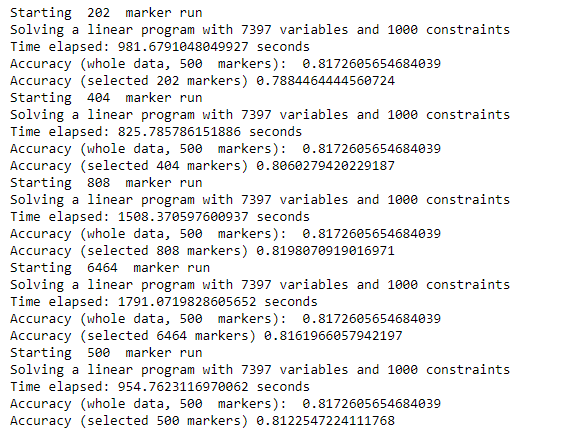

In [129]:
len(testLabel.unique())*32

6464